# Import libaries and load/Inspect Data

In [1]:
# Core Data Analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Time Series libraries
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Crypto data
import yfinance as yf

In [5]:
# Load in daily close prices and rename as price
eth = yf.download('ETH-USD', start='2020-01-01', interval='1d')[['Close']]
eth.rename(columns={"Close": "price"}, inplace=True)
eth.dropna(inplace=True)
eth.tail()

C:\Users\User\AppData\Local\Temp\ipykernel_14600\1882571649.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  eth = yf.download('ETH-USD', start='2020-01-01', interval='1d')[['Close']]
[*********************100%***********************]  1 of 1 completed


Price,price
Ticker,ETH-USD
Date,
2025-10-25,3953.470947
2025-10-26,4157.989258
2025-10-27,4120.122070
2025-10-28,3982.262451
2025-10-30,3884.978027


In [9]:
# Check basic statistics
eth.describe()

Price,price
Ticker,ETH-USD
count,2129.000000
mean,2134.198741
std,1181.517975
min,110.605873
25%,1382.522827
50%,2002.357422
75%,3054.521973
max,4831.348633


In [10]:
# Check for nulls and data types
eth.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2129 entries, 2020-01-01 to 2025-10-30
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   (price, ETH-USD)  2129 non-null   float64
dtypes: float64(1)
memory usage: 33.3 KB


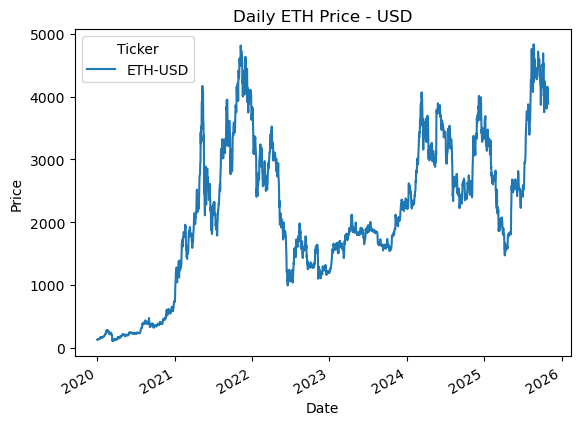

In [8]:
# Plot ETH price over time
eth['price'].plot(title='Daily ETH Price - USD')
plt.ylabel('Price')
plt.show()

In [11]:
# Log transform to handle percentage changes and handle variance
eth['log_price'] = np.log(eth['price'])

# Checking for stationarity/Transformations

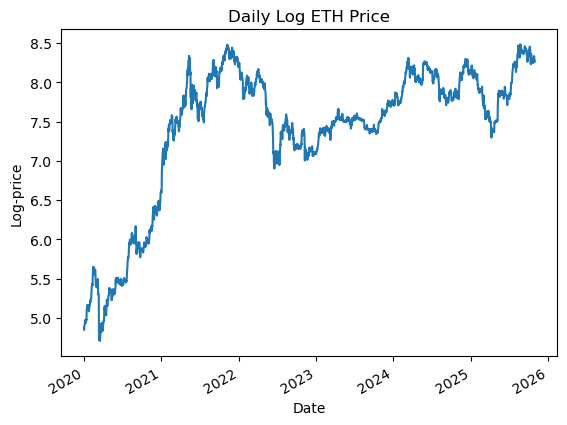

In [12]:
# Plot log transformed price over time
eth['log_price'].plot(title='Daily Log ETH Price')
plt.ylabel('Log-price')
plt.show()

In [14]:
# Run ADF test to check stationarity
results = adfuller(eth['log_price'])
print(f'ADF Statistic: {results[0]: .4f}')
print(f'P-value: {results[1]: .4f}')
for key, value in results[4].items():
    print(f"Critical Value ({key}): {value: .4f}")

ADF Statistic: -2.4161
P-value:  0.1372
Critical Value (1%): -3.4334
Critical Value (5%): -2.8629
Critical Value (10%): -2.5675


We can see that the P-Value for the ADF statistic is above the 0.05 threshold meaning we do not reject the null hypothesis
I.E. there is a unit root and the data is nonstationary